In [1]:
from ConvNet import *
from utils import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13958991479316709824]

## I. Basic operation with tensorFlow

In [3]:
tf.reset_default_graph()

#setup
x = tf.constant(1.,name="input_value")
w = tf.Variable(0.8, name="weight")
y = tf.multiply(w , x, name="output_value")
y_ = tf.constant(0.0)
loss = (y - y_)**2

#Print graph
# monitor_operation()

#Optimizer
train_step = tf.train.GradientDescentOptimizer(0.025).minimize(loss)

#Summary
tf.summary.scalar('ouput', y)
tf.summary.scalar("loss", loss)
merged_summary_op = tf.summary.merge_all()


with tf.Session() as sess:
    summary_writer = tf.summary.FileWriter('log_test-graph')
    summary_writer.add_graph(sess.graph)
    
    init = tf.global_variables_initializer()
    sess.run(init)
    for i in range(100):
        summary_str = sess.run(merged_summary_op)
        summary_writer.add_summary(summary_str, i)
        sess.run(train_step)

**Acces to the tensorboard:**  
*python -m tensorboard.main --logdir=log_test-graph*  
then go to *http://localhost:6006*

## II. Dataset

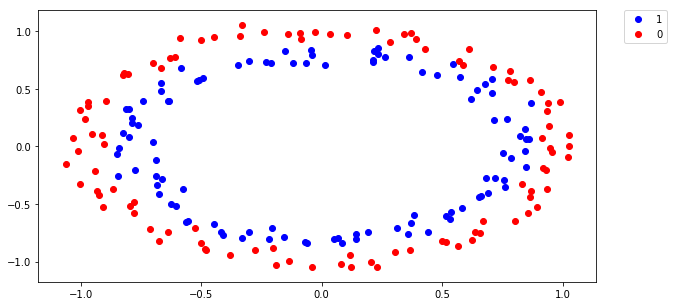

In [4]:
select='circle' # 'blob' or 'moon'
if select == 'moon':
    from sklearn.datasets import make_moons
    X_ori, y_ori = make_moons(n_samples=200, noise=0.1)
elif select == 'blob':
    from sklearn.datasets.samples_generator import make_blobs
    np.random.seed(1)
    X_ori, y_ori = make_blobs(n_samples=200, centers=2, n_features=2)
elif select == 'circle':
    from sklearn.datasets.samples_generator import make_circles
    X_ori, y_ori = make_circles(n_samples=200, noise=0.05)


plt.figure(figsize=(10,5))
plt.scatter(*zip(*X_ori[y_ori==1]), c= 'b', label = '1')
plt.scatter(*zip(*X_ori[y_ori==0]), c= 'r', label = '0')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [5]:
X = X_ori.T
idx=np.random.permutation(X.shape[1])
y=y_ori.reshape(-1,1).T
X_train, X_test = X[:,idx[:int(X.shape[1]*0.8)]], X[:,idx[int(X.shape[1]*0.8):]]
y_train, y_test = y[:,idx[:int(X.shape[1]*0.8)]], y[:,idx[int(X.shape[1]*0.8):]]

## II. Fully Connected Network

### a. Pick the model 

In [6]:
lr_list = [1e-4, 1e-3, 1e-2, 1e-1, 1]
for i,lr in enumerate(lr_list):
    print('learning rate = %s' % lr)
    model=FC_binary_class(X_train, y_train, X_test, y_test)
    model.add_FC(20)
    model.add_FC(10)
    model.add_FC(10)
    model.compile()
    model.train(epoch = 2001 , batch_size = 32,lr = lr, optimizer = 'adam', filename = f'log_graph/lr={lr}')
    print('\n=================================\n')

learning rate = 0.0001
epoch 0, training loss 2.46637, test loss 2.54591, test accuracy 0.55
epoch 300, training loss 0.702345, test loss 0.737302, test accuracy 0.45
epoch 600, training loss 0.634945, test loss 0.713836, test accuracy 0.4
epoch 900, training loss 0.558582, test loss 0.625996, test accuracy 0.625
epoch 1200, training loss 0.464873, test loss 0.517769, test accuracy 0.85
epoch 1500, training loss 0.366091, test loss 0.390207, test accuracy 0.975
epoch 1800, training loss 0.280322, test loss 0.29397, test accuracy 1.0


learning rate = 0.001
epoch 0, training loss 3.34189, test loss 3.47566, test accuracy 0.5
epoch 300, training loss 0.0970781, test loss 0.136085, test accuracy 1.0
epoch 600, training loss 0.0302859, test loss 0.0388743, test accuracy 1.0
epoch 900, training loss 0.0116173, test loss 0.0180482, test accuracy 1.0
epoch 1200, training loss 0.00527112, test loss 0.0159401, test accuracy 1.0
epoch 1500, training loss 0.00275605, test loss 0.0153322, test acc

By checking the learning curves in the tensorboard, we pick **learning rate = 1e-2**

### b. Train the model

In [7]:
lr = 1e-2
model=FC_binary_class(X_train, y_train, X_test, y_test)
model.add_FC(20)
model.add_FC(10)
model.add_FC(10)
model.compile()
model.train(epoch = 2001 , batch_size = 32,lr = lr, optimizer = 'adam', filename = 'log_graph2')

epoch 0, training loss 1.9175, test loss 1.69175, test accuracy 0.55
epoch 300, training loss 0.0688981, test loss 0.183531, test accuracy 0.9
epoch 600, training loss 0.0291629, test loss 0.0225853, test accuracy 1.0
epoch 900, training loss 0.00968909, test loss 0.00431117, test accuracy 1.0
epoch 1200, training loss 0.00613375, test loss 0.00111973, test accuracy 1.0
epoch 1500, training loss 0.0143476, test loss 0.0116159, test accuracy 1.0
epoch 1800, training loss 0.00170073, test loss 0.00594612, test accuracy 1.0


## III Model vizualisation

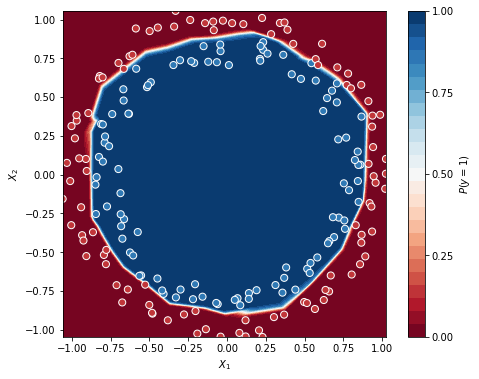

In [8]:
#grid
xx, yy = np.mgrid[np.min(X_ori[:,0]):np.max(X_ori[:,0]):.01, np.min(X_ori[:,1]):np.max(X_ori[:,1]):.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = model.predict_probs(grid.T).reshape(xx.shape)


f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs,25, cmap='RdBu',vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])
ax.scatter(*zip(*X_ori), c= y_ori, s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)


ax.set(aspect="equal", xlim=(np.min(X_ori[:,0]),np.max(X_ori[:,0])), \
       ylim = (np.min(X_ori[:,1]),np.max(X_ori[:,1])) , xlabel="$X_1$", ylabel="$X_2$")
plt.show()